In [3]:
import os
import sys
import warnings

# Path = '/remote/tychodata/ftairli/work/Projects/LSTM_Reconstruction/Models'
# if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')

from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch


hostname = os.uname()
if 'tedtop' in hostname: sys.path.append('/home/fedor-tairli/work/CDEs/Dataset/')


from Dataset2 import ProcessingDatasetContainer

if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')



In [4]:
# Model_Name   = 'Model_NLRE_with_Conv3d'
# Model_Name   = 'Model_NLRE_with_Conv3d_BatchShuffle'
# Model_Name   = 'Model_NLRE_with_Conv3d_AllIn_BatchShuffle'
# Model_Name   = 'Model_NLRE_with_Conv3d_AllIn_BatchShuffle_SDPOnly'

Model_Name = 'Model_SDP_NLRE_with_Conv'
Model_Name = 'Model_SDP_NLRE_with_Conv_GaussianShift'

Dataset_Name = 'NLRE_SDP_Dataset'
Dataset_Name = 'NLRE_SDP_Dataset_PixStatus4'

In [6]:
hostname

posix.uname_result(sysname='Linux', nodename='tycho.physics.adelaide.edu.au', release='3.10.0-1160.88.1.el7.x86_64', version='#1 SMP Tue Mar 7 15:41:52 UTC 2023', machine='x86_64')

#### Loading Data and Models, Processing Predictions

In [7]:
if 'tycho' in hostname or 'tycho' in hostname.nodename:
    Models_Path  = '/remote/tychodata/ftairli/work/CDEs/NLREapproach/Models'
    Dataset_Path = '/remote/tychodata/ftairli/work/CDEs/NLREapproach/Data/'
if 'tedtop' in hostname:
    Models_Path  = '/home/fedor-tairli/work/CDEs/NLREapproach/Models'
    Dataset_Path = '/home/fedor-tairli/work/CDEs/NLREapproach/Data/'

# append models path to path
sys.path.append(Models_Path)


In [8]:
# Load Model and Tracker Here
Model = torch.load(f'{Models_Path}/{Model_Name}.pt')
Tracker = torch.load(f'{Models_Path}/{Model_Name}_Tracker.pt')
print(Model.Description)


    Convolutional Neural Network for SDP Reconstruction
    Uses standard Conv2d Layers in blocks with residual connections
    Reconstruction is done for triple telescopes
    First split, and run the input conv on 3 telescopes individually
    Then concatenate the results and run  main conv layers
    This model does not do max pooling
    Uses Gaussian Shift augmentation
    


In [9]:
# Import Dataset Here

# datapath = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/'
# Dataset = ProcessingDatasetContainer(datapath)
Dataset = torch.load(f'{Dataset_Path}/{Dataset_Name}.pt')
print(Dataset.Name)
print(Dataset.Truth_Keys)
print(f'Dataset Length : {len(Dataset)}')
Dataset.AssignIndices()
# Dataset.State = 'Train'
# print(len(Dataset))

Unassigned_CDEsDataset
('SDPTheta', 'SDPPhi')
Dataset Length : 375911


In [10]:
# Some Information
print(f'Final Epoch             : {len(Tracker.EpochLoss["Total"])  } ')
if len(Tracker.EpochLoss)>10 :
    print(f'Epoch 10 Loss           : {Tracker.EpochLoss    ["Total"][9]} ')
    print(f'Epoch 10 Validation Loss: {Tracker.EpochValLoss ["Total"][9]} ')
print(f'Final Loss              : {Tracker.EpochLoss    ["Total"][-1]}')
print(f'Final Validation Loss   : {Tracker.EpochValLoss ["Total"][-1]}')


Final Epoch             : 10 
Final Loss              : 1.5560135387377052
Final Validation Loss   : 1.8666865825653076


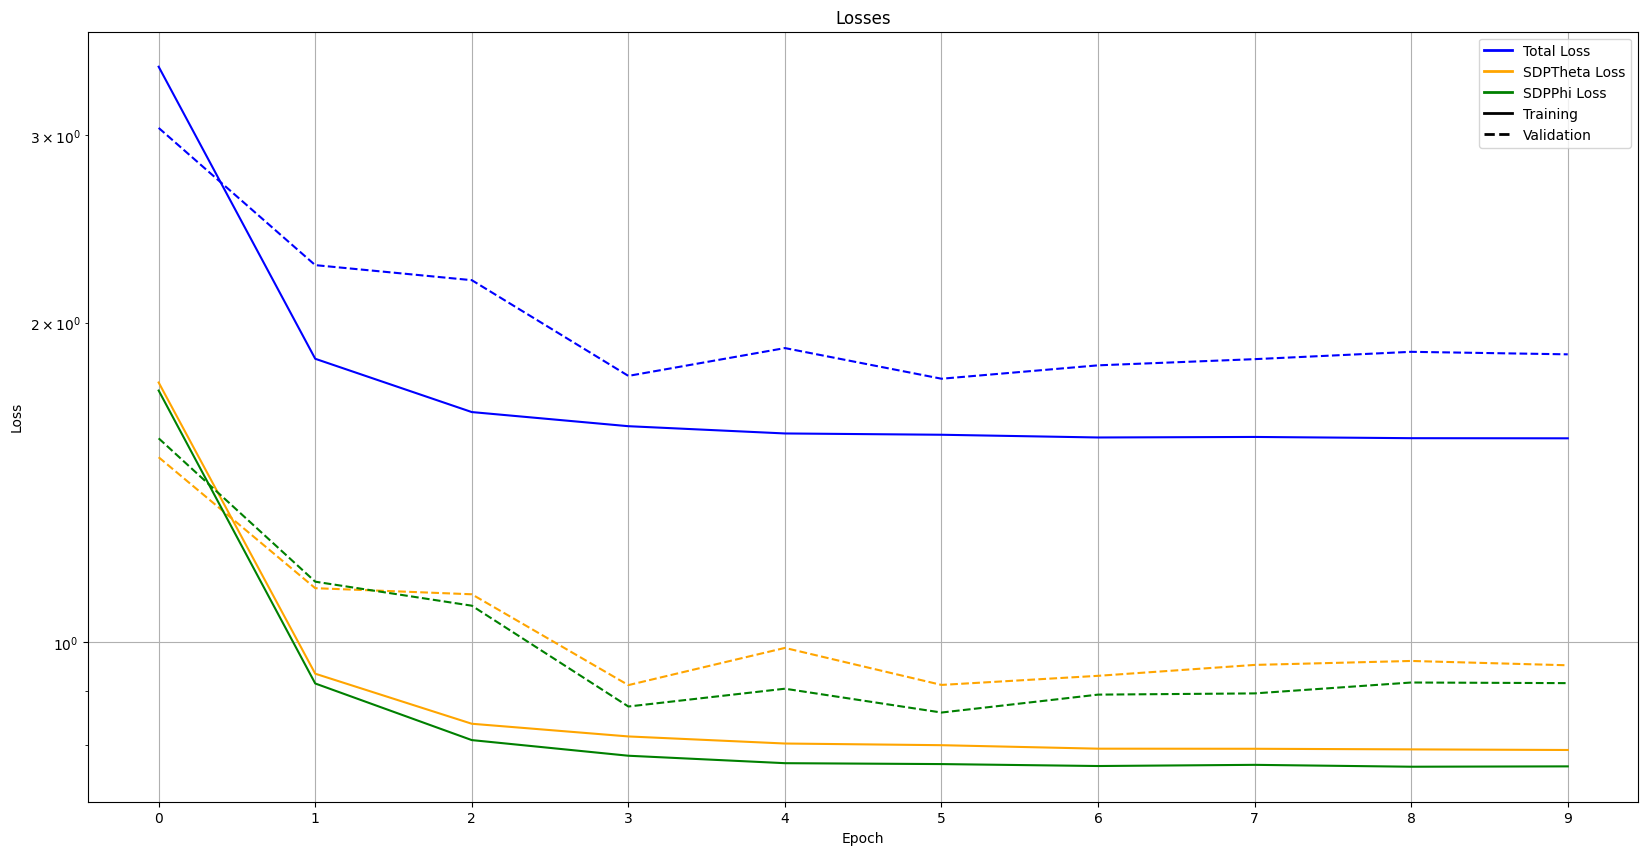

In [11]:
# Loss Plot
EpochLosses    = Tracker.EpochLoss
EpochValLosses = Tracker.EpochValLoss
Keys = list(EpochLosses.keys())
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    plt.plot(EpochLosses[Keys[i]]   , color=colors[i], label=Keys[i] + ' - Training')
    plt.plot(EpochValLosses[Keys[i]], color=colors[i], label=Keys[i] + ' - Validation', linestyle='dashed')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Loss')

custom_lines+= [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='dashed')]
custom_keys += ['Training', 'Validation']


ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid()

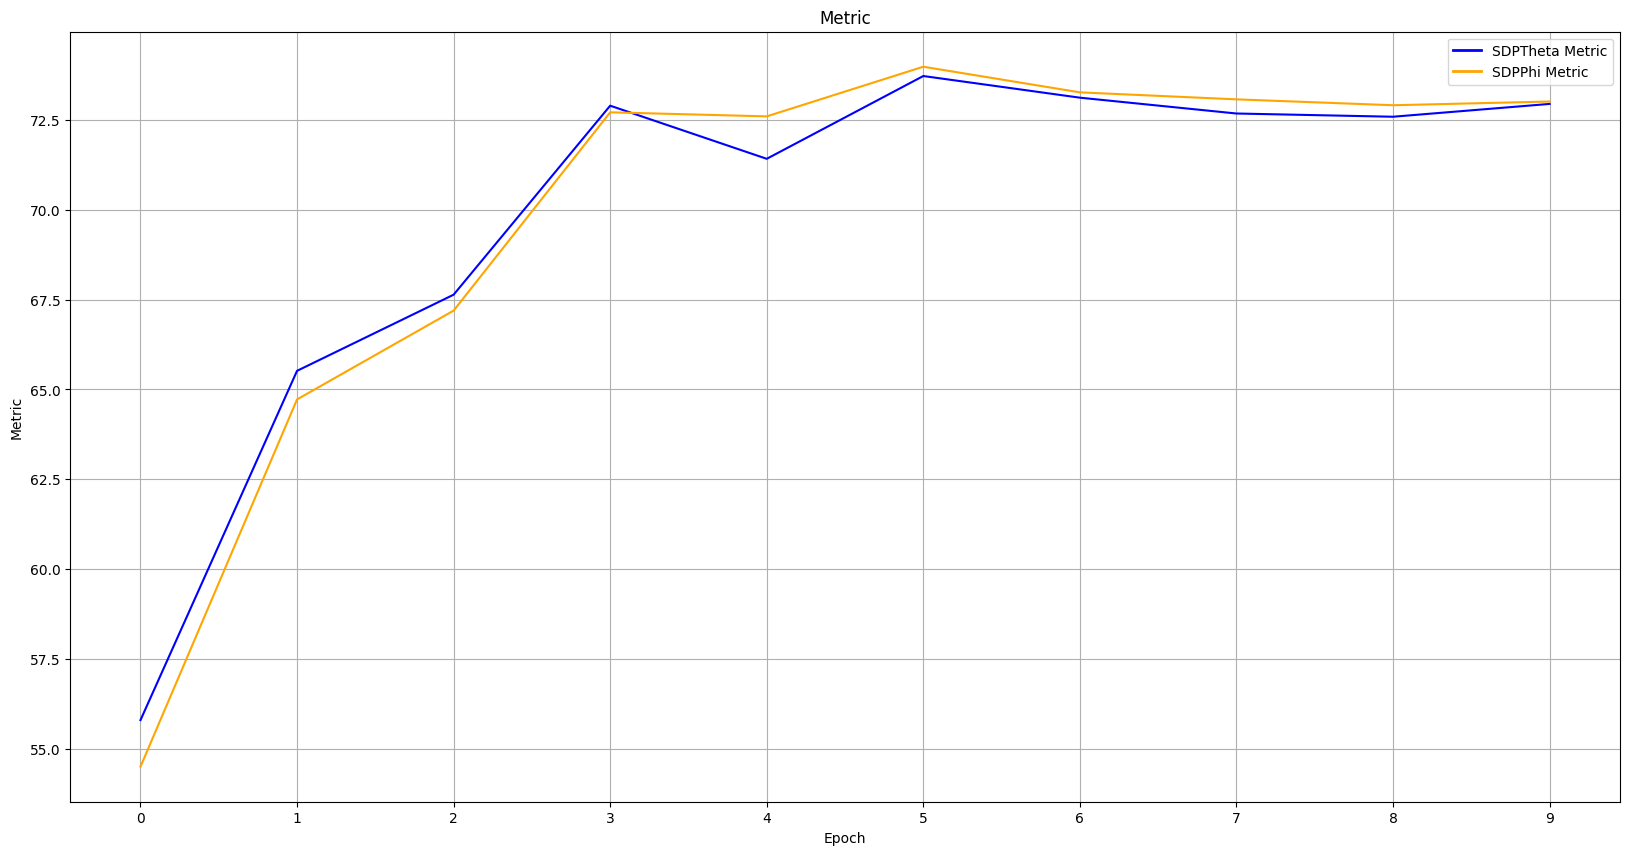

In [12]:
# Metric Plot

# Loss Plot
EpochMetrics    = Tracker.EpochMetric
Keys  = Dataset.Truth_Keys
Units = Dataset.Truth_Units
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    plt.plot(np.array(EpochMetrics[Keys[i]])     , color=colors[i], label=Keys[i] + ' - Metric')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Metric')



ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Metric')
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric')
# ax.set_yscale('log')
ax.grid()

In [13]:
# Define some metrics
def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean() if type(Truths) != torch.Tensor else (torch.abs(Truths-Predictions)).mean()
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68) if type(Truths) != torch.Tensor else torch.quantile(torch.abs(Truths-Predictions),0.68)

In [14]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
Model.to(device)
torch.cuda.empty_cache()

Dataset.State      = 'Test'
# Dataset.BatchSize  = len(Dataset)//256
Dataset.BatchSize  = 64
Dataset.RandomIter = False

Truth   = []
Rec     = []
Pred    = []
RecVals = []


Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # print(f'Event {EvI}/{len(Dataset)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = Dataset._Aux.mean(dim=0)

        Truth .append(BatchTruth)
        Rec   .append(BatchRec)
        
        Model_Out = Model(BatchMains, BatchAux)
        Pred   .append(Model_Out[0].cpu())
        RecVals.append(Model_Out[1].cpu())
        
        
        EvI+=1
        # if EvI == 10: break

print()
Truth   = torch.cat(Truth  , dim=0)
Rec     = torch.cat(Rec    , dim=0)
Pred    = torch.cat(Pred   , dim=0)
RecVals = torch.cat(RecVals, dim=0)

# Augmentation scale
Augmetation_Scale = RecVals.shape[0] // Truth.shape[0]
Truth = Truth.repeat_interleave(Augmetation_Scale, dim=0)
Rec   = Rec  .repeat_interleave(Augmetation_Scale, dim=0)

Truth_labels = (RecVals == Truth).float()
Pred_labels  = (Pred > 0.5 ).float()




Truth   = Truth.numpy()
Rec     = Rec  .numpy()
Pred    = Pred .numpy()
RecVals = RecVals.numpy()

Truth_labels = Truth_labels.numpy()
Pred_labels  = Pred_labels.numpy()



print(Truth.shape)
print(Pred.shape)




(75184, 2)
(75184, 2)


In [15]:
print(f'Augmetation_Scale: {Augmetation_Scale}')

Augmetation_Scale: 2


In [16]:
# Compute Metric
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

# Metric is Accuracy for classification this time


for i in range(len(TruthKeys)):
    Key = TruthKeys[i]

    Accuracy = (Truth_labels[:,i] == Pred_labels[:,i]).mean()
    print(f'Accuracy for {Key:15s} : {Accuracy*100:6.2f} %')
    

Accuracy for SDPTheta        :  72.72 %
Accuracy for SDPPhi          :  72.90 %


In [17]:
print(f'Truth Labels Positive percentage = {Truth_labels.mean(axis=0)*100}')
print(f'Pred  Labels Positive percentage = {Pred_labels.mean(axis=0)*100}')

Truth Labels Positive percentage = [50. 50.]
Pred  Labels Positive percentage = [52.62689 54.9053 ]


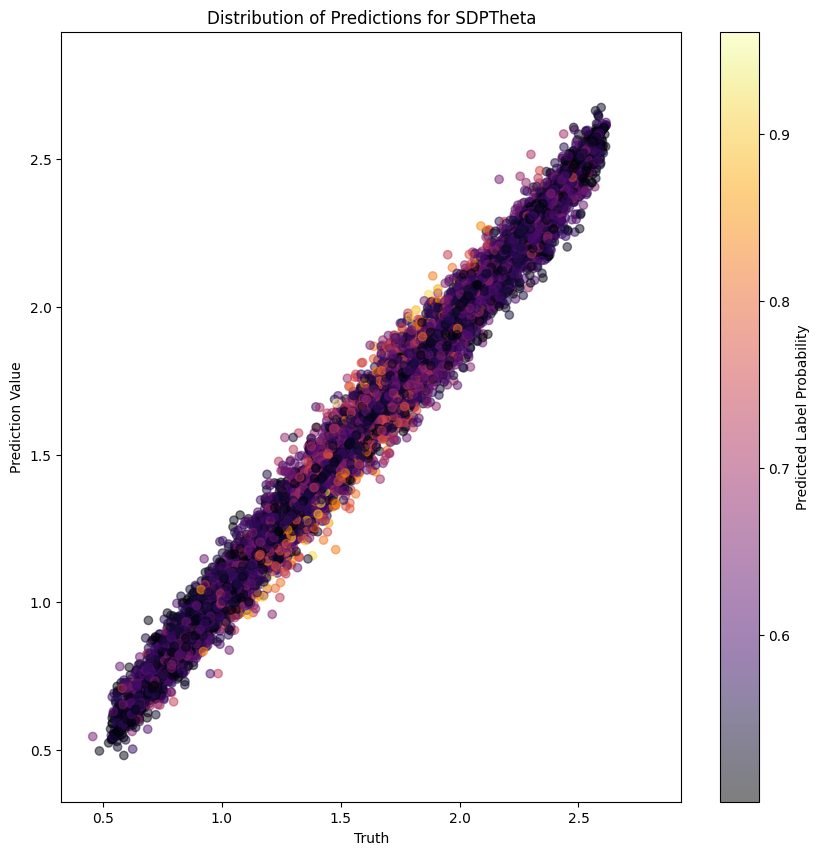

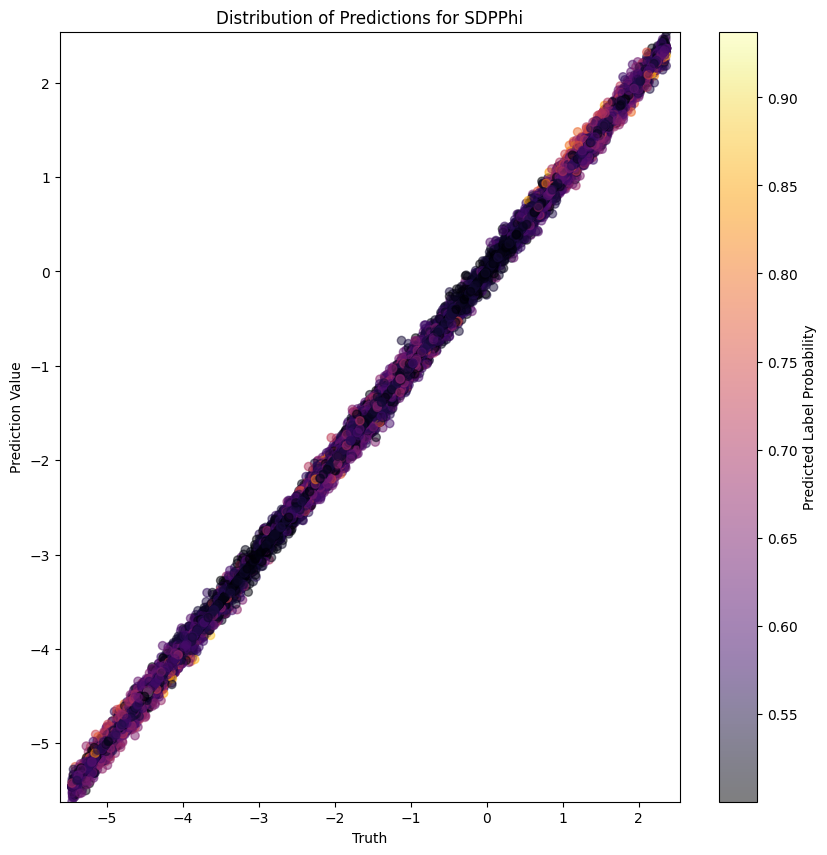

In [18]:
for i, key in enumerate(TruthKeys):
    
    plt.figure(figsize=(10,10))
    plt.title(f'Distribution of Predictions for {key}')
    Threshold = 0.5
    Mask = Pred[:,i]>=Threshold

    # plt.scatter(Truth[::,i], RecVals[::,i], alpha=0.1,c = Pred[:,i], cmap='inferno')
    # plt.scatter(Truth[::,i], RecVals[::,i], alpha=1,c = Pred[:,i], cmap='inferno')
    plt.scatter(Truth[Mask,i], RecVals[Mask,i], alpha=0.5,c = Pred[Mask,i], cmap='inferno', label='Predicted Positive')
    plt.xlabel('Truth')
    plt.ylabel('Prediction Value')
    # Set Equal Limits
    min_val = min(Truth[:,i].min(), RecVals[:,i].min())
    max_val = max(Truth[:,i].max(), RecVals[:,i].max())
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.colorbar(label='Predicted Label Probability',alpha=1.0)
    plt.show()
    

Plotting for SDPTheta
Plotting for SDPPhi


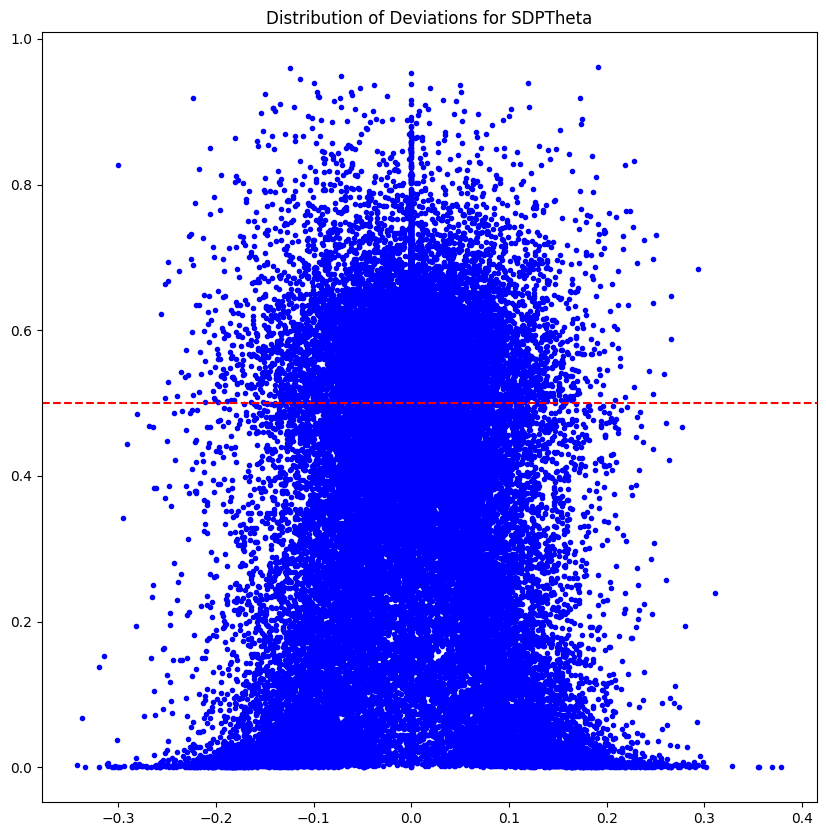

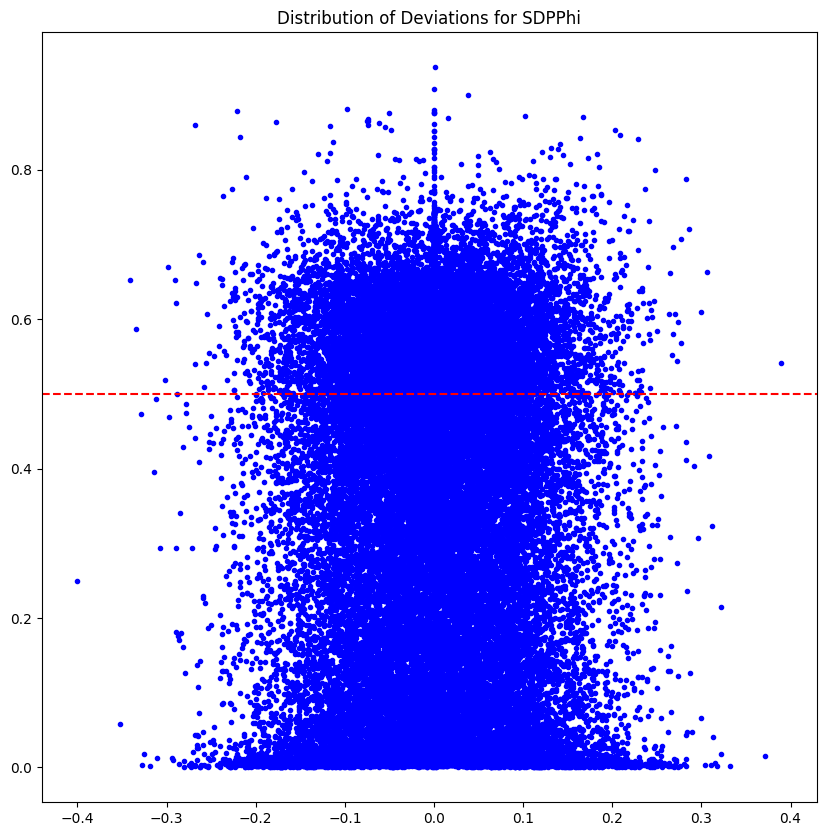

In [19]:
for i,key in enumerate(TruthKeys):
    print(f'Plotting for {key}')

    Deviations = RecVals[:,i] - Truth[:,i]

    plt.figure(figsize=(10,10))
    plt.title(f'Distribution of Deviations for {key}')

    plt.scatter(Deviations,Pred[:,i], alpha=1,c = 'blue',marker='.')    
    plt.axhline(0.5, color='red', linestyle='dashed', label='Decision Boundary')

#### Variational Method on 1 event


In [20]:
import pandas as pd
AllPossiblePixelDirections = pd.read_csv('../../ReadingData/camera_view_table_with_HEAT_down.txt',sep=' ',header=None,names = ['EyeID','TelID','PixID','Theta','Phi'])
AllPossiblePixelDirections.head()

,EyeID,TelID,PixID,Theta,Phi
0,1,1,1,1.61140,358.419
1,1,1,2,2.86980,359.174
2,1,1,3,4.13764,358.434
3,1,1,4,5.38773,359.205
4,1,1,5,6.66357,358.476


In [21]:
# Select a telescope Skeleton
TelescopeID = 3
EyeID       = 5
TelescopePixels = AllPossiblePixelDirections[ (AllPossiblePixelDirections['TelID'] == TelescopeID) & (AllPossiblePixelDirections['EyeID'] == EyeID) ]

def XYToIndex(Xs, Ys, return_tensor=False):
    """
    Convert X, Y coordinates back to pixel indices.
    Inverse of IndexToXY function.
    
    Parameters:
    -----------
    Xs : torch.Tensor or list
        X coordinates (row indices)
    Ys : torch.Tensor or list
        Y coordinates (column indices)
    return_tensor : bool
        If True, return as tensor; if False, return as list
    
    Returns:
    --------
    indices : torch.Tensor or list
        Pixel indices (1-indexed)
    """
    # Convert to tensors if needed
    if not isinstance(Xs, torch.Tensor):
        Xs = torch.tensor(Xs)
    if not isinstance(Ys, torch.Tensor):
        Ys = torch.tensor(Ys)
    
    # Reverse the operation: indices = Xs * 22 + Ys + 1
    indices = Xs * 22 + Ys + 1
    
    if return_tensor:
        return indices.int()
    else:
        return indices.int().tolist()

In [22]:
TelescopePixels.head(440)

,EyeID,TelID,PixID,Theta,Phi
11440,5,3,1,30.0461,61.4742
11441,5,3,2,31.1840,62.5506
11442,5,3,3,32.5453,61.9059
11443,5,3,4,33.6691,63.0322
11444,5,3,5,35.0387,62.3946
...,...,...,...,...,...
11875,5,3,436,50.7897,22.9124
11876,5,3,437,51.7342,21.1252
11877,5,3,438,53.1711,21.5827
11878,5,3,439,54.0805,19.6488


In [23]:
event_class_labels = {
    0: 'Shower Candidate',
    1: 'Close Shower',
    2: 'Horizontal Shower',
    3: 'Large Event',
    4: 'Muon + Noise',
    5: 'Long Muon',
    6: 'Noise',
    7: 'Muon'
}
print(Dataset.Aux_Keys)

('Gen_LogE', 'Gen_Xmax', 'Gen_Chi0', 'Gen_Rp', 'Gen_SDPTheta', 'Gen_SDPPhi', 'Gen_EventClass', 'Gen_Primary', 'Gen_CosZenith', 'Gen_CherenkovFraction')


Inspecting Event 123948120
True Values:
  SDPTheta        : 1.7867 rad (102.37 deg)

True Values:
  SDPTheta        : 1.7867 rad (102.37 deg)
  SDPPhi          : -1.8126 rad (-103.85 deg)



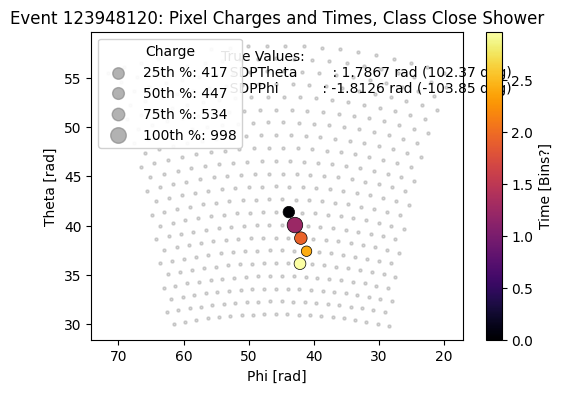

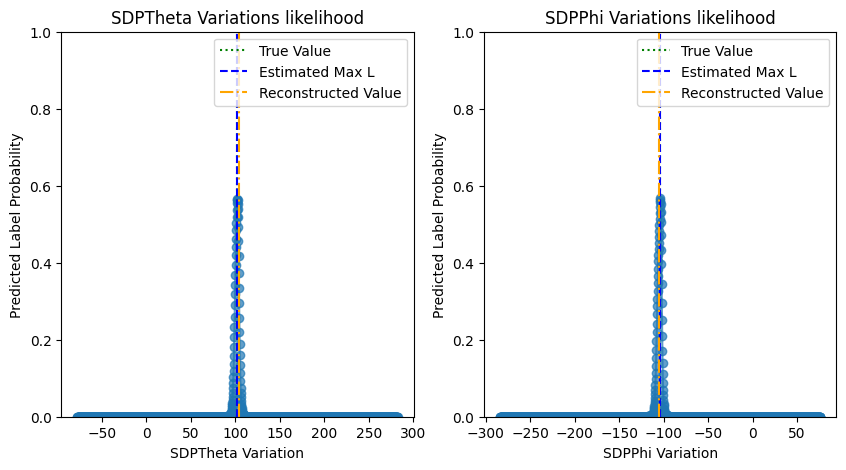

In [24]:
for j in range(1):
    # Pick a random event
    Dataset.State = 'Test'
    Dataset.BatchSize = 1
    N = np.random.randint(len(Dataset))
    # N = 16

    for i,(EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec) in enumerate(Dataset):
        if i == N:break
        else: continue
    Main    = BatchMains[0] if BatchMains[0].ndim == 4 else BatchMains[1]
    RecVals = BatchMains[1] if BatchMains[0].ndim == 4 else BatchMains[0]

    

    Event_Class = BatchAux[0,Dataset.Aux_Keys.index('Gen_EventClass')]
    Event_Class_Name = event_class_labels.get(Event_Class.int().item(), 'Unknown')

    

    if True: # Event plot
        print(f'Inspecting Event {EventIndex.int().item()}')

        # print('Ground Truth:')
        This_Truth = f'True Values:\n'
        for k,key in enumerate(Dataset.Truth_Keys):
            if Dataset.Truth_Units[k] == 'rad':
                This_Truth += f'  {key:15s} : {BatchTruth[0,k].item():.4f} {Dataset.Truth_Units[k]} ({np.degrees(BatchTruth[0,k].item()):.2f} deg)\n'
                # print(This_Truth)
            else:
                This_Truth += f'  {key:15s} : {BatchTruth[0,k].item():.4f} {Dataset.Truth_Units[k]}\n'
            print(This_Truth)

        XYs = torch.nonzero(Main[0,0]>0.0, as_tuple=False)
        Pixel_Indices = XYToIndex(XYs[:,0], XYs[:,1], return_tensor=False)

        Charges = Main[0,0, XYs[:,0], XYs[:,1]].cpu().numpy()
        Times   = Main[0,1, XYs[:,0], XYs[:,1]].cpu().numpy()
        
        # Unnormalise for plots
        # assuming original normalisation was log10(torch.clamp_min(Charge,0)+1)/3.75
        Charges = 10**(Charges*3.75)-1
        Times   = Times*40

        Phis   = TelescopePixels.set_index('PixID').loc[Pixel_Indices]['Phi'  ].values
        Thetas = TelescopePixels.set_index('PixID').loc[Pixel_Indices]['Theta'].values

        fig, ax = plt.subplots(figsize=(6, 4))
        root_scale = 0.7
        # Main scatter
        scatter = ax.scatter(Phis, Thetas, s=Charges**root_scale, c=Times, cmap='inferno', 
                            edgecolors='black', linewidths=0.5)

        # Background pixels
        ax.scatter(TelescopePixels['Phi'], TelescopePixels['Theta'], 
                c='gray', s=5, alpha=0.3, zorder=0)

        # Size legend
        charge_percentiles = np.percentile(Charges, [25, 50, 75, 100])
        for i, pct in enumerate([25, 50, 75, 100]):
            charge_val = np.percentile(Charges, pct)
            size_val = charge_val**root_scale
            ax.scatter([], [], s=size_val, c='gray', alpha=0.6, 
                    label=f'{pct}th %: {charge_val:.0f}')

        ax.legend(title='Charge', loc='upper left', framealpha=0.9)
        plt.colorbar(scatter, label='Time [Bins?]', ax=ax)
        ax.set_xlabel('Phi [rad]')
        ax.set_ylabel('Theta [rad]')
        ax.set_title(f'Event {EventIndex.int().item()}: Pixel Charges and Times, Class {Event_Class_Name}')
        ax.grid(False)
        ax.invert_xaxis()

        ax.text(0.35, 0.75, This_Truth, transform=ax.transAxes, fontsize=10)

    if True: # Variation plot


        Variation_Scale = 180
        Step = 0.1

        N_Variations = int(Variation_Scale//Step + 1)
        Variation_Scale *= np.pi/180
        
        Variations = torch.linspace(-Variation_Scale, Variation_Scale, N_Variations)
        Variations = torch.stack([Variations,Variations],dim=1)  # Shape (N_Variations, 2)

        
        RecVals = RecVals.repeat(N_Variations,1) + Variations

        Main = Main.repeat(N_Variations,1,1,1)
        # print(f'Main shape: {Main.shape}')
        # print(f'RecVals shape: {RecVals.shape}')

        Model.eval()
        with torch.no_grad():
            Model_Out = Model((Main,RecVals),Aux = None, Augmentation_Scale = 1)
        Preds   = Model_Out[0].cpu().numpy()
        RecVals = RecVals.numpy()
        
        fig, ax = plt.subplots(1,Preds.shape[1],figsize=(10, 5))

        for i,key in enumerate(Dataset.Truth_Keys):
            ax[i].plot(np.rad2deg(RecVals[:,i]), Preds[:,i], marker='o', linestyle='-', alpha=0.7)

            ax[i].axvline(np.rad2deg(BatchTruth[0,i].item()), color='green', linestyle=':', label='True Value')
            ax[i].set_title(f'{key} Variations likelihood')
            ax[i].set_xlabel(f'{key} Variation')
            ax[i].set_ylabel('Predicted Label Probability')

            Estimated_max = RecVals[np.argmax(Preds[:,i]),i]
            ax[i].axvline(np.rad2deg(Estimated_max), color='blue', linestyle='dashed', label='Estimated Max L')

            ax[i].axvline(np.rad2deg(BatchRec[0,i].item()), color='orange', linestyle='-.', label='Reconstructed Value')
            ax[i].legend()
            ax[i].grid(False)
            ax[i].set_ylim(0, 1)
        
        

#### Statistical Analysis of the NLRE preds

In [22]:
Results = []
Dataset.State     = 'Test'
Dataset.BatchSize = 1
    
for i,(EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec) in enumerate(Dataset):
    
    Main    = BatchMains[0] if BatchMains[0].ndim == 4 else BatchMains[1]
    RecVals = BatchMains[1] if BatchMains[0].ndim == 4 else BatchMains[0]
    
    Variation_Scale = 180
    Step = 0.1

    N_Variations = int(Variation_Scale//Step + 1)
    Variation_Scale *= np.pi/180
    
    Variations = torch.linspace(-Variation_Scale, Variation_Scale, N_Variations)
    Variations = torch.stack([Variations,Variations],dim=1)  # Shape (N_Variations, 2)

    
    RecVals = RecVals.repeat(N_Variations,1) + Variations

    Main = Main.repeat(N_Variations,1,1,1)
    # print(f'Main shape: {Main.shape}')
    # print(f'RecVals shape: {RecVals.shape}')

    Model.eval()
    with torch.no_grad():
        Model_Out = Model((Main,RecVals),Aux = None, Augmentation_Scale = 1)
    Preds   = Model_Out[0].cpu().numpy()
    RecVals = RecVals.numpy()
    Estimated_max_indices = np.argmax(Preds, axis=0)
    

    This_Result = {'EventIndex': EventIndex.int().item()}
    for k,key in enumerate(Dataset.Truth_Keys):
        Estimated_max = RecVals[Estimated_max_indices[k],k]
        This_Result[f'Estimated_{key}'] = Estimated_max
        This_Result[f'True_{key}']      = BatchTruth[0,k].item()
        This_Result[f'Rec_{key}'] = BatchRec[0,k].item()


    for k,key in enumerate(Dataset.Aux_Keys):
        This_Result[f'{key}'] = BatchAux[0,k].item()

    Results.append(This_Result)
    if i % 10 == 0:
        print(f'Processed {i}/{len(Dataset)} events', end='\r')
    
    # if i == 100: break

print()
Results_df = pd.DataFrame(Results)

    

Processed 37590/37592 events


In [24]:
# Save Results to CSV
Results_df.to_csv(f'../Results/{Model_Name}_TestSet_Results.csv', index=False)

In [ ]:
Results_df.head()

,EventIndex,Estimated_SDPTheta,True_SDPTheta,Rec_SDPTheta,Estimated_SDPPhi,True_SDPPhi,Rec_SDPPhi,Gen_LogE,Gen_Xmax,Gen_Chi0,Gen_Rp,Gen_SDPTheta,Gen_SDPPhi,Gen_EventClass,Gen_Primary,Gen_CosZenith,Gen_CherenkovFraction
0,862752768,1.670538,1.075050,1.360110,-5.162359,-5.317780,-5.062464,15.638200,662.909973,2.53918,963.630005,1.075050,0.142134,5.0,2212.0,0.498125,97.124001
1,304440896,0.652637,0.664861,0.662577,-0.136234,-0.130995,-0.152195,16.114599,505.924988,1.47719,1509.589966,0.664861,-1.704060,4.0,2212.0,0.614222,91.335701
2,577326336,2.098413,1.859170,1.882210,-4.601362,-4.679945,-4.661483,16.300699,566.971008,2.58903,1413.520020,1.859170,0.779968,1.0,26056.0,0.502770,93.223099
3,278488640,1.945680,1.978860,2.009490,2.128235,2.178878,2.244214,16.108200,593.690979,2.14116,969.549011,1.978860,-0.186916,4.0,7014.0,0.772468,89.315300
4,665506944,0.919827,0.918081,0.914235,-0.323603,-0.318365,-0.315554,16.341400,560.033020,1.74836,1132.290039,0.918081,-1.891430,0.0,7014.0,0.781891,82.048798


Total Points before cuts 37592
SDPTheta Total Points after cuts 37592
SDPPhi Total Points after cuts 37592


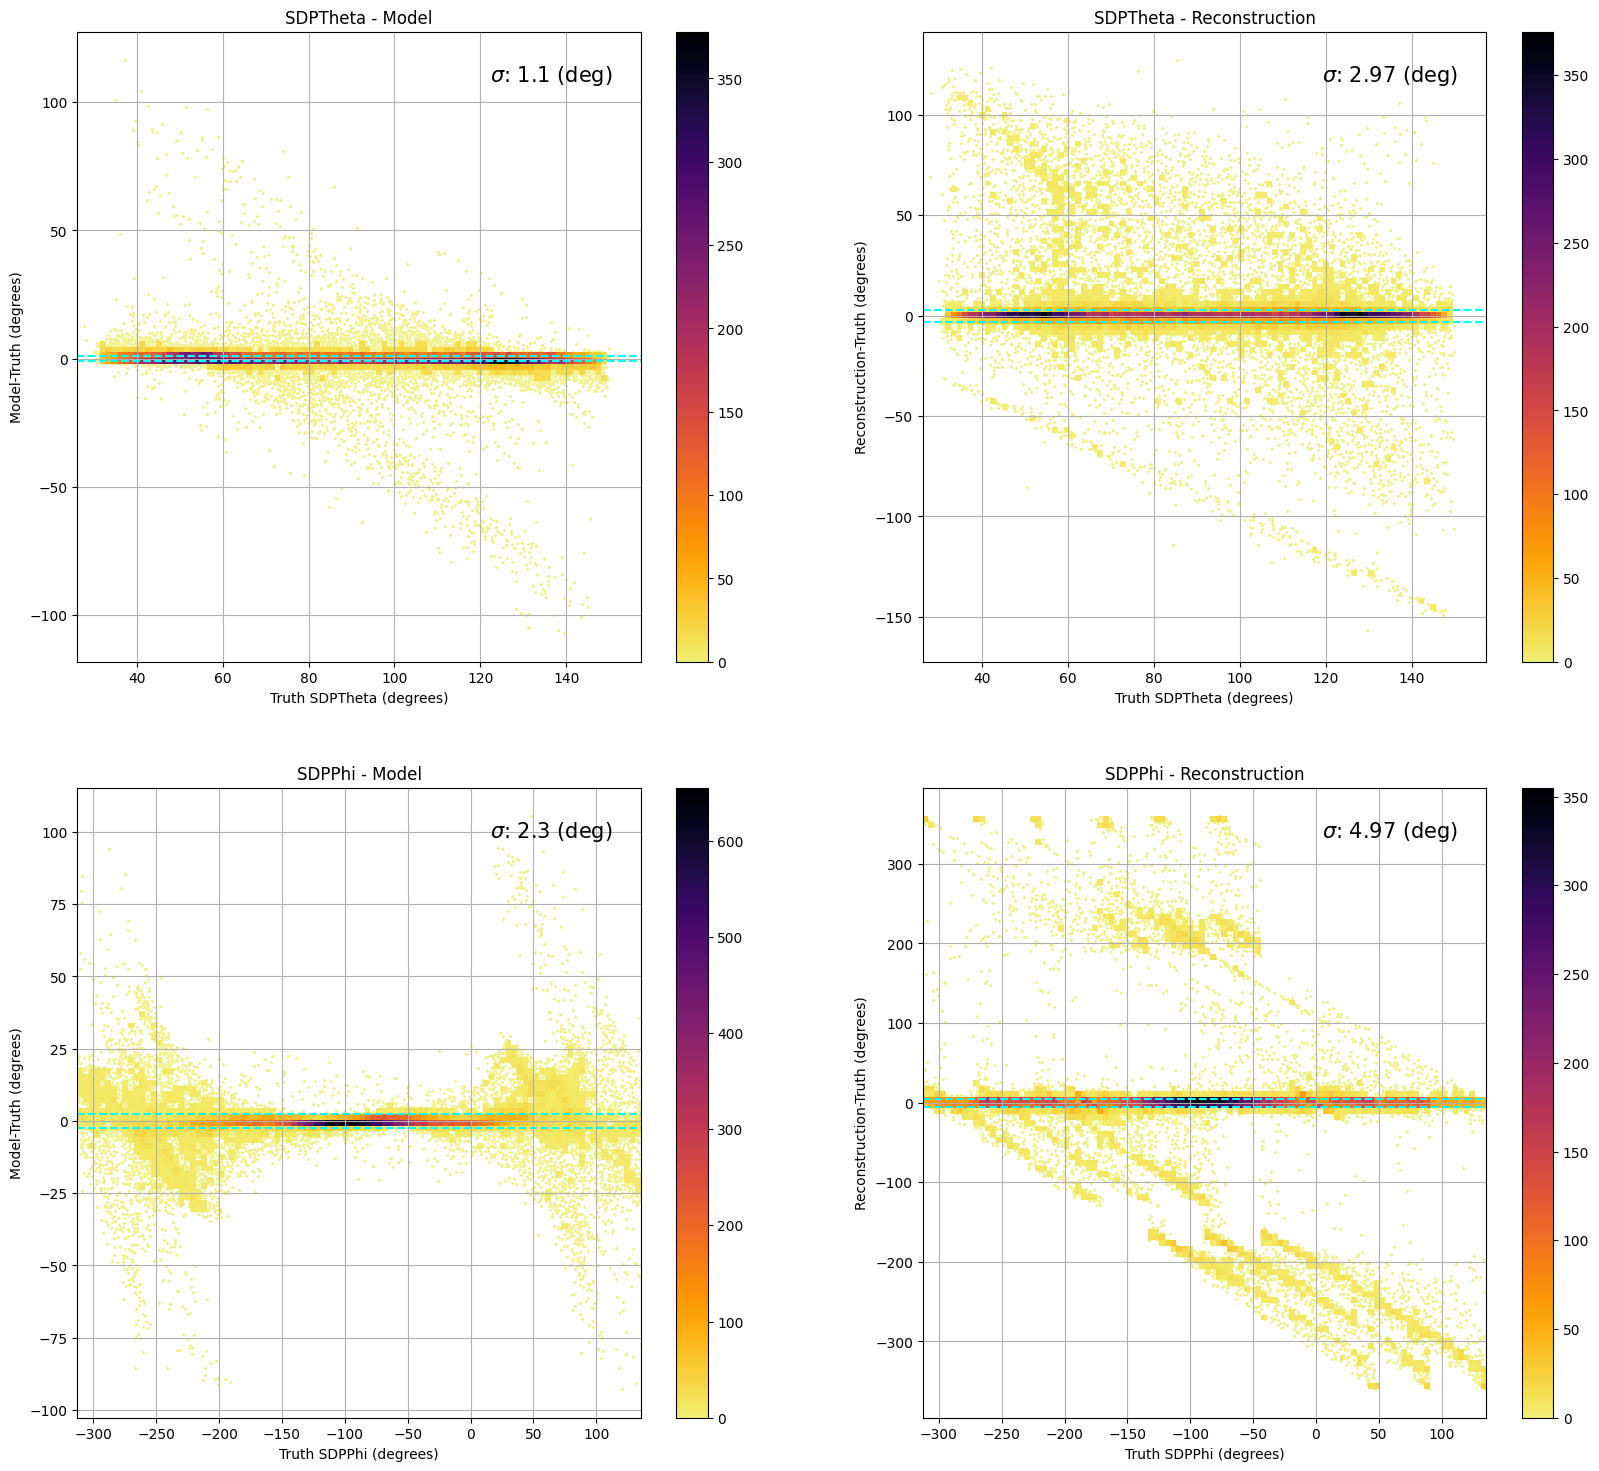

In [28]:
from matplotlib.colors import LinearSegmentedColormap

# Create a truncated version of the inferno colormap (first 90%)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'truncated_{cmap.name}', 
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Original inferno colormap
inferno = plt.get_cmap('inferno_r')

# Truncated colormap: first 90%
truncated_inferno = truncate_colormap(inferno, 0.05, 1)

def CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec):
    plt.style.use('default')
    fig, ax = plt.subplots(len(TruthKeys),2, figsize=(20,9*len(TruthKeys)))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        if   TruthKeys[i] == 'SDPTheta': cut = (np.abs(Yp)>0)  #& (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'SDPPhi'  : cut = (np.abs(Yp)>0)  #& (np.abs(Yp)<20)    & (np.abs(Yr)<20) #   & (np.abs(X)<50)
        elif TruthKeys[i] == 'Chi0'    : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'Rp'      : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'CEDist'  : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'T0'      : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        elif TruthKeys[i] == 'Xmax'    : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        elif TruthKeys[i] == 'LogE'    : cut = (X>0)             # & (np.abs(Yp)<3000)    & (np.abs(Yr)<3000)
        elif TruthKeys[i] == 'z'       : cut = (X>0.4) 
        else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # Secondary Y_lim cuts for scaling
        # Yp_STD = np.percentile(np.abs(Yp),68)
        # cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        # X  = X [cut]
        # Yp = Yp[cut]
        # Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color=truncated_inferno(0))


        sns.histplot(x=X, y=Yp, ax=ax[i,0], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[i,1], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[i,0].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[i,1].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[i,0].set_ylabel(f'Model-Truth (degrees)')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[i,1].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[i,0].set_title(f'{TruthKeys[i]} - Model')
        ax[i,1].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[i,0].set_xlim(min(X),max(X))
        ax[i,1].set_xlim(min(X),max(X))

        ax[i,0].grid()
        ax[i,1].grid()

        # ax[0,1].set_facecolor('lightgrey')
        # ax[1,1].set_facecolor('lightgrey')


        # 68th Percentile
        Percentile68_p = np.percentile(np.abs(Yp),68)
        Percentile68_r = np.percentile(np.abs(Yr),68)

        # ax[i,0].set_ylim(-Percentile68_p*5,Percentile68_p*5)
        # ax[i,1].set_ylim(-Percentile68_p*5,Percentile68_p*5)



        # Add as a texbox to top right of plot
        if TruthUnits[i]!= 'rad':
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)

        else:
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)



        ax[i,0].axhline(Percentile68_p, color='cyan', linestyle='--')
        ax[i,0].axhline(-Percentile68_p, color='cyan', linestyle='--')

        ax[i,1].axhline(Percentile68_r, color='cyan', linestyle='--')
        ax[i,1].axhline(-Percentile68_r, color='cyan', linestyle='--')
        
    return fig
    
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units
Truth = np.array(Results_df[[f'True_{key}'      for key in TruthKeys]].values)
Pred  = np.array(Results_df[[f'Estimated_{key}' for key in TruthKeys]].values)
Rec   = np.array(Results_df[[f'Rec_{key}'       for key in TruthKeys]].values)

figure = CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
# figure.savefig(f'../Results/{Model_Name}_Combined_Deviation.png')

#### Finding out the uncertainty and using variations as measure

N = 636
Inspecting Event 209288144
N_Variations per angle: 361
Variations shape: torch.Size([130321, 2])
Total Variations: 130321


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Preds Shape (130321, 2)


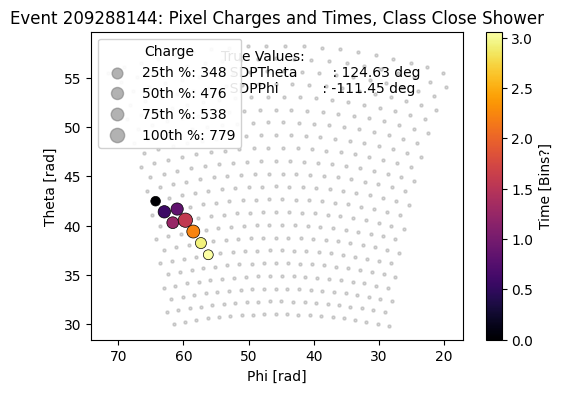

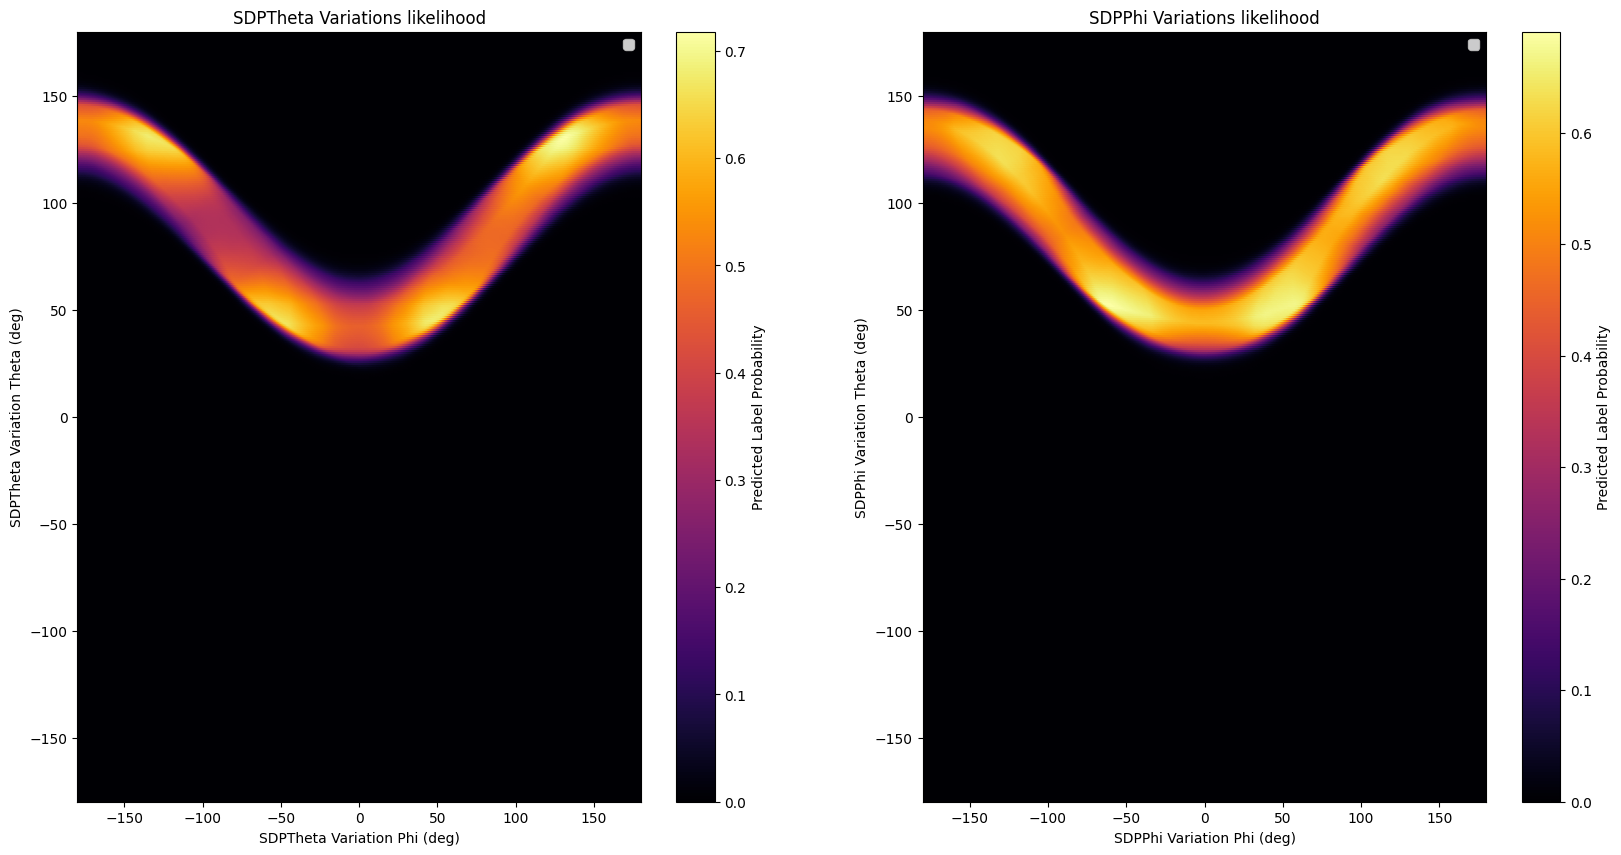

In [28]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths



for j in range(1):
    # Pick a random event
    Dataset.State = 'Test'
    Dataset.BatchSize = 1
    N = np.random.randint(len(Dataset))
    # N = 16
    # N= 22464
    print(f'N = {N}')

    for i,(EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec) in enumerate(Dataset):
        if i == N:break
        else: continue
    Main    = BatchMains[0] if BatchMains[0].ndim == 4 else BatchMains[1]
    RecVals = BatchMains[1] if BatchMains[0].ndim == 4 else BatchMains[0]

    

    Event_Class = BatchAux[0,Dataset.Aux_Keys.index('Gen_EventClass')]
    Event_Class_Name = event_class_labels.get(Event_Class.int().item(), 'Unknown')

    

    if True: # Event plot
        print(f'Inspecting Event {EventIndex.int().item()}')

        # print('Ground Truth:')
        This_Truth = f'True Values:\n'
        for k,key in enumerate(Dataset.Truth_Keys):
            if Dataset.Truth_Units[k] == 'rad':
                This_Truth += f'  {key:15s} : {np.degrees(BatchTruth[0,k].item()):.2f} deg\n'
                # print(This_Truth)
            else:
                This_Truth += f'  {key:15s} : {BatchTruth[0,k].item():.4f} {Dataset.Truth_Units[k]}\n'
            # print(This_Truth)

        XYs = torch.nonzero(Main[0,0]>0.0, as_tuple=False)
        Pixel_Indices = XYToIndex(XYs[:,0], XYs[:,1], return_tensor=False)

        Charges = Main[0,0, XYs[:,0], XYs[:,1]].cpu().numpy()
        Times   = Main[0,1, XYs[:,0], XYs[:,1]].cpu().numpy()
        
        # Unnormalise for plots
        # assuming original normalisation was log10(torch.clamp_min(Charge,0)+1)/3.75
        Charges = 10**(Charges*3.75)-1
        Times   = Times*40

        Phis   = TelescopePixels.set_index('PixID').loc[Pixel_Indices]['Phi'  ].values
        Thetas = TelescopePixels.set_index('PixID').loc[Pixel_Indices]['Theta'].values

        fig, ax = plt.subplots(figsize=(6, 4))
        root_scale = 0.7
        # Main scatter
        scatter = ax.scatter(Phis, Thetas, s=Charges**root_scale, c=Times, cmap='inferno', 
                            edgecolors='black', linewidths=0.5)

        # Background pixels
        ax.scatter(TelescopePixels['Phi'], TelescopePixels['Theta'], 
                c='gray', s=5, alpha=0.3, zorder=0)

        # Size legend
        charge_percentiles = np.percentile(Charges, [25, 50, 75, 100])
        for i, pct in enumerate([25, 50, 75, 100]):
            charge_val = np.percentile(Charges, pct)
            size_val = charge_val**root_scale
            ax.scatter([], [], s=size_val, c='gray', alpha=0.6, 
                    label=f'{pct}th %: {charge_val:.0f}')

        ax.legend(title='Charge', loc='upper left', framealpha=0.9)
        plt.colorbar(scatter, label='Time [Bins?]', ax=ax)
        ax.set_xlabel('Phi [rad]')
        ax.set_ylabel('Theta [rad]')
        ax.set_title(f'Event {EventIndex.int().item()}: Pixel Charges and Times, Class {Event_Class_Name}')
        ax.grid(False)
        ax.invert_xaxis()

        ax.text(0.35, 0.75, This_Truth, transform=ax.transAxes, fontsize=10)



    if True: # Variation plot


        Variation_Scale = 180
        Step = 0.5


        N_Variations = int(Variation_Scale//Step + 1)
        print(f'N_Variations per angle: {N_Variations}')
        Variation_Scale *= np.pi/180
        


        Variations = torch.linspace(-Variation_Scale, Variation_Scale, N_Variations)
        Theta_variations, Phi_variations = torch.meshgrid(Variations, Variations, indexing='ij')
        Variations = torch.stack([Theta_variations.flatten(), Phi_variations.flatten()], dim=1)
        
        print(f'Variations shape: {Variations.shape}')
        Total_Variations = Variations.shape[0]
        print(f'Total Variations: {Total_Variations}')
        
        
        
        
        # RecVals = RecVals.repeat(N_Variations,1) + Variations
        RecVals  = Variations #+ BatchTruth.repeat(N_Variations,1)
        
        Main = Main.repeat(Total_Variations,1,1,1)
        
        Model.eval()
        All_Preds   = []
        All_RecVals = []
        Batch_Size = 128
        with torch.no_grad():
            for start_idx in range(0, Total_Variations, Batch_Size):
                end_idx = min(start_idx + Batch_Size, Total_Variations)
                Batch_Main    = Main   [start_idx:end_idx]
                Batch_RecVals = RecVals[start_idx:end_idx]
                
                Model_Out = Model((Batch_Main,Batch_RecVals),Aux = None, Augmentation_Scale = 1)
                All_Preds  .append(Model_Out[0].cpu())
                All_RecVals.append(Model_Out[1].cpu())
        
        Preds   = torch.cat(All_Preds  , dim=0).numpy()
        RecVals = torch.cat(All_RecVals, dim=0).numpy()
        print(f'Preds Shape {Preds.shape}')
        
        Thetas = np.rad2deg(RecVals[:,0])
        Phis   = np.rad2deg(RecVals[:,1])

        fig, ax = plt.subplots(1,Preds.shape[1],figsize =(20, 10))

        for i,key in enumerate(Dataset.Truth_Keys):
            sc = ax[i].scatter(Phis, Thetas, c=Preds[:,i], cmap='inferno', s=20, marker='o')
            plt.colorbar(sc, ax=ax[i], label='Predicted Label Probability')
            ax[i].set_title(f'{key} Variations likelihood')
            ax[i].set_xlabel(f'{key} Variation Phi (deg)')
            ax[i].set_ylabel(f'{key} Variation Theta (deg)')

            # Estimated_max = RecVals[np.argmax(Preds[:,i]),i]
            # ax[i].axhline(np.rad2deg(BatchTruth[0,i].item()), color='green' , linestyle=':' , label='True Value')
            # ax[i].axhline(np.rad2deg(BatchRec[0,i].item())  , color='orange', linestyle='-.', label='Reconstructed Value')

            ax[i].legend()
            ax[i].grid(False)
            ax[i].set_xlim(-Variation_Scale*180/np.pi, Variation_Scale*180/np.pi)
            ax[i].set_ylim(-Variation_Scale*180/np.pi, Variation_Scale*180/np.pi)

        # fig, ax = plt.subplots(1,Preds.shape[1],figsize=(20, 10))

        # for i,key in enumerate(Dataset.Truth_Keys):
        #     print(f'Plotting for {key}')
        #     ax[i].plot(np.rad2deg(RecVals[:,i]), Preds[:,i], marker='', linestyle='-', alpha=0.7)
        #     # ax[i].scatter(np.rad2deg(RecVals[:,i]), Preds[:,i], marker='.',s = 1, linestyle='-', alpha=0.7)



        #     ax[i].set_title(f'{key} Variations likelihood')
        #     ax[i].set_xlabel(f'{key} Variation')
        #     ax[i].set_ylabel('Predicted Label Probability')

        #     Estimated_max = RecVals[np.argmax(Preds[:,i]),i]
        #     ax[i].axvline(np.rad2deg(BatchTruth[0,i].item()), color='green' , linestyle=':' , label='True Value')
        #     ax[i].axvline(np.rad2deg(Estimated_max)         , color='blue'  , linestyle='--', label='Estimated Max L')
        #     ax[i].axvline(np.rad2deg(BatchRec[0,i].item())  , color='orange', linestyle='-.', label='Reconstructed Value')

        #     ax[i].legend()
        #     ax[i].grid(False)
        #     ax[i].set_ylim(0, 1)

        #     # peaks, properties = find_peaks(Preds[:,i],distance = 50,height = 0.3)  # threshold can be tuned
        #     # widths, width_heights, left_ips, right_ips = peak_widths(Preds[:,i], peaks, rel_height=0.75)
        #     # print(f'Found peaks at indices: {np.rad2deg(RecVals[peaks,i])} with widths: {widths*Step} deg, with heights: {properties["peak_heights"]}')
        #     # for i_peak, peak_idx in enumerate(peaks):
        #     #     peak_pos = np.rad2deg(RecVals[peak_idx, i])
        #     #     peak_height = Preds[peak_idx, i]
        #     #     ax[i].plot(peak_pos, peak_height, "x", color='red')